# Imports

In [1]:
!pip install logzero
import os
import io
import re
import argparse

import logging
import logzero
from logzero import logger

import datetime
import pandas as pd
import numpy as np

import tqdm
import warnings
import itertools as it
import ast
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import json
from sklearn import decomposition
import tensorflow as tf
import tensorflow.compat.v1 as tfc
from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Mount and clone repository to get helpers functions

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir(os.path.join('drive', 'MyDrive'))

Mounted at /content/drive/


In [3]:
print(os.path.join(os.getcwd(), "nlp_consulting_project"))
if os.path.exists(os.path.join(os.sep, 'content', 'drive', 'MyDrive', 'Capgemini', "nlp_consulting_project")):
    print("Directory nlp_consulting_project exists")
    os.chdir(os.path.join(os.sep, 'content', 'drive', 'MyDrive', 'Capgemini', "nlp_consulting_project"))
    !git pull

    if not os.path.exists(os.path.join('scraper', 'scraped_data', 'merged_data', 'merged_reviews.json')):
        try:
            os.mkdir(os.path.join('scraper', 'scraped_data', 'merged_data'))
        except:
            pass

        from scraper.merger import merge_files
        scraped_data_dir = os.path.join('scraper', 'scraped_data')
        merge_files(os.path.join(scraped_data_dir, 'reviews'), os.path.join(scraped_data_dir, 'merged_data', 'merged_reviews.json'))
    os.chdir(os.path.join("attention_embedder", "src"))

else:
    !git clone https://github.com/hehlinge42/nlp_consulting_project.git

    os.chdir("nlp_consulting_project")
    try:
        os.mkdir(os.path.join('scraper', 'scraped_data', 'merged_data'))
    except:
        pass
    
    from scraper.merger import merge_files
    scraped_data_dir = os.path.join('scraper', 'scraped_data')
    merge_files(os.path.join(scraped_data_dir, 'reviews'), os.path.join(scraped_data_dir, 'merged_data', 'merged_reviews.json'))
    os.chdir(os.path.join("attention_embedder", "src"))

/content/drive/My Drive/nlp_consulting_project
Cloning into 'nlp_consulting_project'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 11231 (delta 15), reused 20 (delta 10), pack-reused 11203
Receiving objects: 100% (11231/11231), 1.25 GiB | 23.41 MiB/s, done.
Resolving deltas: 100% (3940/3940), done.
Checking out files: 100% (3353/3353), done.


[I 210308 16:54:54 merger:70] Merging 8 files


In [4]:
# from han import HierarchicalAttentionNetwork
from loading import *
from skipgram import Skipgram
from preprocessing import review_preprocessing

In [5]:
!unzip ../data/weights_json.zip -d ../data
!7z x ../data/weights_gz.7z -o../data
!unzip ../data/balanced_dataset_gz.zip -d ../data

Archive:  ../data/weights_json.zip
  inflating: ../data/weights_json.json  

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../data/                  1 file, 96533866 bytes (93 MiB)

Extracting archive: ../data/weights_gz.7z
--
Path = ../data/weights_gz.7z
Type = 7z
Physical Size = 96533866
Headers Size = 138
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      2% - weights_gz.json                        6% - weights_gz.json                        9% - weights_gz.json                       12% - weights_gz.json                       15% - weights_gz.json        

# Hp Optimizer

This class reproduces the bevaviour of GridSearchCV providing Tensorboard support. It enables to test a model with different combinations of hyper-parameters.

In [6]:
# from embedder.src.universal_hp_optimizer import UniversalHPOptimizer

DEFAULT_PARAMS = {
    "epochs": [10],
    'batch_size': [32],
    'batch_normalization': [False],
    'dropout': [0],
    'optimizer': ['adam'],
    'early_stopping': [3],
    'nb_columns': [-1]
}

class UniversalHPOptimizer():
    """ A class to optimize a given model and a given dictionary of parameters
    to test. It uses the Tensorboard API in order to log the results.
    
    """

    def __init__(self, dict_params, create_model, log_dir="logs/fit/", print_summary=False):
        """
        Args:
            dict_params ([dict]): [Dictionary which values are lists of possible
             values for each parameter to test in the GridSearch.]
            create_model ([funct]): [Function to create the model.]
            print_summary (bool, optional): [Whether to print a summary of the model.
            ]. Defaults to False.
        """
        self.user_input = dict_params
        self.create_model = create_model
        self.print_summary=print_summary
        self.best_model = None
        self.best_accuracy = None
        self.METRIC_ACCURACY = 'accuracy'
        self.log_dir = log_dir
        self.params = self.generate_hp_dict(dict_params)


    def generate_hp_dict(self, dict_params):
        
        ret = {}
        for k, v in DEFAULT_PARAMS.items():
            if k not in dict_params.keys():
                ret[k] = v
            else:
                ret[k] = dict_params[k]
        
        for k, v in dict_params.items():
            if k not in ret:
                ret[k] = v

        return ret


    def run_all(self, x_train, x_test, y_train=None, y_test=None):
        """[summary]

        Args:
          x_train ([ndarray]): [Array containing the training images.]
          y_train ([ndarray]): [Array containing the labels of the training 
          images.]
          x_test ([ndarray]): [Array containing the training images.]
          y_test ([ndarray]): [Array containing the labels of the training 
          images.]
        """

        session_num = 1

        keys, values = zip(*self.params.items())
        combinations = [dict(zip(keys, v)) for v in it.product(*values)]

        for hparams in combinations:
            run_name = "run-%d" % session_num
            print('\n--- Starting trial: %s' % run_name)
            print({k: v for k, v in hparams.items()})
            self.run(hparams, x_train, y_train, x_test, y_test, 'logs/hparam_tuning/' + run_name)
            session_num += 1


    def train_test_model(self, hparams, x_train, y_train, x_test, y_test):
        """[summary]

        Args:
            hparams ([dict]): [A dictionary of model parameters. The available
            parameters are :
            - batch_normalization (boolean): Adds two Batch normalization layers
            before the dropout layers. 
            - optimizer (str) : Type of optimizer to use.
            - dropout (float) : The dropout rate, between 0 and 1.
            - batch_size (int): size of the batch.
            - epoch (int): number of epochs.
            ]
            x_train ([ndarray]): [Array containing the training images.]
            y_train ([ndarray]): [Array containing the labels of the training 
            images.]
            x_test ([ndarray]): [Array containing the training images.]
            y_test ([ndarray]): [Array containing the labels of the training 
            images.]

        Returns:
            [float]: [Returns the scalar test loss of the test.]
        """
        model = self.create_model(hparams, self.print_summary)
        log_dir = os.path.join(self.log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

        if hparams['nb_columns'] != -1:
            x_train = x_train.iloc[:, 0:hparams['nb_columns']]
            x_test = x_test.iloc[:, 0:hparams['nb_columns']]

        params_callback = {}
        for k, v in hparams.items():
            if k in self.user_input:
                params_callback[k] = v

        tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
                                hp.KerasCallback(log_dir, params_callback),
                                tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=hparams["early_stopping"], verbose=1)]

        if y_train is None or y_test is None:
            # Assume batch dataset
            model.fit(x_train, batch_size=hparams["batch_size"], epochs=hparams["epochs"],
                callbacks=[tensorboard_callback], validation_data=x_test) 
            _, accuracy = model.evaluate(x_test)
        else:
            model.fit(x_train, y_train, batch_size=hparams["batch_size"], epochs=hparams["epochs"],
                    callbacks=[tensorboard_callback], validation_split=0.2) 
            _, accuracy = model.evaluate(x_test, y_test)

        if self.best_accuracy is None or accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.best_model = model
            self.best_params = hparams

        return accuracy

    def run(self, hparams, x_train, y_train, x_test, y_test, run_dir="."):
        """[summary]

        Args:
            hparams ([dict]): [A dictionary of model parameters. The available
            parameters are :
            - batch_normalization (boolean): Adds two Batch normalization layers
            before the dropout layers. 
            - optimizer (str) : Type of optimizer to use.
            - dropout (float) : The dropout rate, between 0 and 1.
            - batch_size (int): size of the batch.
            - epoch (int): number of epochs.
            ]
            x_train ([ndarray]): [Array containing the training images.]
            y_train ([ndarray]): [Array containing the labels of the training 
            images.]
            x_test ([ndarray]): [Array containing the training images.]
            y_test ([ndarray]): [Array containing the labels of the training 
            images.]
            run_dir (str, optional): [Path to the directory from which to run 
            the model.]. Defaults to ".".
        """

        with tf.summary.create_file_writer(run_dir).as_default():
            hp.hparams(hparams)  # record the values used in this trial
            accuracy = self.train_test_model(hparams, x_train, y_train, x_test, y_test)
            tf.summary.scalar(self.METRIC_ACCURACY, accuracy, step=1)

 
    def predict(self, x_test):
        """ Predicts the results for x_test with the model.

        Args:
            x_test ([ndarray]): [Array containing the training images.]

        Returns:
            [tuple]: [Returns an array of weights for predictions and an 
            array of predicted labels.]
        """
        predicted_probas = self.best_model.predict(x_test, verbose=1, max_queue_size=10)
        predicted_classes = np.argmax(predicted_probas, axis=-1)
        return predicted_probas, predicted_classes


    def get_confusion_matrix(self, y_true, x_test=None, y_pred=None, labels=None):
        """ Builds a confusion matrix for the model.

        Args:
            y_true ([ndarray]): [Array containing the true labels.]
            x_test ([ndarray]): [Array containing the training images.]. Defaults to None.
            y_pred ([ndarray]): [Array containing the weigths for the prediction.]. Defaults to None.
            labels ([list], optional): [List containing all of the unique labels.]. Defaults to None. 

        Returns:
            [DataFrame]: [Returns a pandas DataFrame containing the confusion matrix, 
            with the rows being the true labels and the columns the predicted labels.]
        """
        if labels is not None:
            real_labels = ["real " + label for label in labels]
            pred_labels = ["pred " + label for label in labels]
        else:
            real_labels, pred_labels = None, None

        if y_pred is None:
            _, y_pred = self.predict(x_test)
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
        if real_labels is not None and pred_labels is not None:
            conf_matrix = pd.DataFrame(conf_matrix, index=real_labels, columns=pred_labels)
        return conf_matrix


    def plot_evaluation_info(self, conf_matrix):
        """ Shows 3 confusion matrices for the model.

        Args:
            conf_matrix ([ndarray or pd.DataFrame]): [confusion matrix with absolute values]

        Returns: [None]
        """

        fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
        conf_matrix_norm_recall = conf_matrix / (np.sum(conf_matrix, axis=1).to_numpy().reshape(len(conf_matrix), 1))
        conf_matrix_norm_precision = conf_matrix / np.sum(conf_matrix, axis=0)
        
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', ax=ax[0]).set_title("Absolute value confusion matrix")
        sns.heatmap(conf_matrix_norm_recall, annot=True, fmt='.2%', cmap='Blues', ax=ax[1]).set_title("Recall confusion matrix")
        sns.heatmap(conf_matrix_norm_precision, annot=True, fmt='.2%', cmap='Blues', ax=ax[2]).set_title("Precision confusion matrix")
        plt.show()

# HAN

The HAN class has been modified to support the hyper-parameter optimizer. It now implements masking for embedding layer, l1-l2 regularizations, dropout and recurrent dropout

In [7]:
from attention import Attention

class HierarchicalAttentionNetwork(tf.keras.Model):
    """Hierarchical Attention Network implementation.

    Reference :
    * Hierarchical Attention Networks for Document Classification : https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

    """
    def __init__(self, vocab_size, embedding_dim, attention_units, 
                 classifier_units,
                 hparams, pretrained_weights=None):
        
        """Hierarchical Attention Network class constructor.

        """
        super(HierarchicalAttentionNetwork, self).__init__()
        
        self.word_attention = []
        self.document_attention = []

        if pretrained_weights is not None:
            initializer = tf.keras.initializers.Constant(pretrained_weights)
        else:
            initializer = "uniform"

        # Regularisation
        self.dropout_embedding = hparams['dropout_embedding']

        # Main Layers
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            embeddings_initializer=initializer,
            trainable=hparams['trainable'],
            mask_zero=hparams["mask_zero"]
        )
        self.WordGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=hparams['gru_units'],
                activation=hparams["activation"],
                return_sequences=True,
                recurrent_dropout=hparams['recurrent_dropout']
            ), 
            merge_mode='concat',
        )
        self.WordAttention = Attention(units=attention_units)

        self.SentenceGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=hparams['gru_units'],
                activation=hparams["activation"],
                return_sequences=True,
                recurrent_dropout=hparams['recurrent_dropout']
            ), 
            merge_mode='concat',
        )
        self.SentenceAttention = Attention(units=attention_units)

        self.fc = tf.keras.layers.Dense(units=classifier_units, activation=tf.keras.activations.softmax, 
                                        activity_regularizer=eval(hparams['regularizer']))


    def call(self, inputs):
        """Model forward method.
        """
        # sentences_vectors, word_attention = self.word_to_sentence_encoder(inputs)
        # self.word_attention.append(word_attention)
        # document_vector, document_attention = self.sentence_to_document_encoder(sentences_vectors)
        # self.document_attention.append(document_attention)

        sentences_vectors, _ = self.word_to_sentence_encoder(inputs)
        document_vector, _ = self.sentence_to_document_encoder(sentences_vectors)

        return self.fc(document_vector)

    def word_to_sentence_encoder(self, inputs):
        """Given words from each sentences, encode the contextual representation of 
        the words from the sentence with Bidirectional GRU and Attention, and output 
        a sentence_vector.
        """
        x = self.embedding(inputs)
        mask = self.embedding.compute_mask(inputs)
        if self.dropout_embedding > 0.0:
          x = tf.keras.layers.Dropout(self.dropout_embedding)(x)
        x = tf.keras.layers.TimeDistributed(self.WordGRU)(x, mask=mask)
        context_vector, attention_weights = self.WordAttention(x)

        return context_vector, attention_weights
    
    def sentence_to_document_encoder(self, sentences_vectors):
        """Given sentences from each review, encode the contextual representation of 
        the sentences with Bidirectional GRU and Attention, and output 
        a document vector.
        """
        # sentence encoder (using bidirectionnal GRU)
        sentences_vectors = self.SentenceGRU(sentences_vectors)        
        # document vector  (using attention at sentence level)
        document_vector, attention_weights = self.SentenceAttention(sentences_vectors)
        
        return document_vector, attention_weights

# Loading pretrained weights

We support both Capgemini data and data we scraped on TripAdvisor directly. Our scraped data is a dataset of 20k reviews with equal representation of each class (rating 1 to 5)

In [19]:
try:
    path_list = os.getcwd().split(os.sep)
    target_index = path_list.index('nlp_consulting_project')
    running_dir = os.path.join('.', path_list[target_index + 1])
    path_list = path_list[:target_index + 1]
    os.chdir(os.path.join(os.sep, *path_list))
except:
    pass

filepath = os.path.join("attention_embedder", "data", "weights_" + 'json' + ".json")

with open(filepath, 'r') as weights_file:
    logger.info(f'Loading pretrained weights from JSON file {filepath}')
    weights = json.load(weights_file)

[I 210308 17:00:46 <ipython-input-19-50125bd851d6>:13] Loading pretrained weights from JSON file attention_embedder/data/weights_json.json


# Loading train and test

In [15]:
# DISCLAIMER: run cell again if eval raises an error

data_fp = os.path.join('scraper', 'scraped_data', 'merged_data', 'merged_reviews.json')

balanced_df = get_balanced_df('json', data_fp)
sequences, vocab_size, tokenizer = gen_sequences(balanced_df, 'json')
preprocessed_reviews_dict = preprocess_per_model(balanced_df, tokenizer, 'json', models=["han"])
train_ds_han, test_ds_han = get_train_test_df(balanced_df, preprocessed_reviews_dict, 'han')

[I 210308 16:59:32 loading:71] Looks for save_fp: scraper/scraped_data/merged_data/balanced_dataset_json.csv
[I 210308 16:59:32 loading:77] Reading balanced dataset csv as scraper/scraped_data/merged_data/balanced_dataset_json.csv found.
[I 210308 16:59:32 loading:80] Returns balanced dataset
[C 210308 16:59:32 loading:131] review_sentences = ["['went to this restaurant for the first time on 07 04  lovely customer service  great tasting food apart from the sticky toffee pudding which was hideous and not worth anywhere near  5  they have you the tiniest scoop of ice cream to go with it  even though the food and service were good i have to overall give a rating of 1 as my friend and i both suffered from food poisoning  for this reason we will never go back']", "['food was good but cold  service average  we had the 3 courses for  33 per person and had a total of 5 drinks  final bill of  135  shocked  going back to dispute the 6th drink that we didn t have tomorrow  tip of the day   check 

# Optimizing the parameters of the model

In [ ]:
%load_ext tensorboard

In [16]:
# tf.config.experimental_run_functions_eagerly(False)

def generate_model(hparams, print_summary=False):

    print(hparams["weights"])
    model = HierarchicalAttentionNetwork(vocab_size=len(weights[hparams['weights']]), embedding_dim=128, attention_units=32, 
                classifier_units=5, hparams=hparams, pretrained_weights=weights[hparams['weights']])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                           optimizer=hparams["optimizer"], metrics=["accuracy"])#run_eagerly=False
    
    return model

params = {
    "epochs": [20],
    'early_stopping': [5],
    'weights': ['20'], # pretrained weights after 20 epochs
    'optimizer': ["adam"],
    'activation': ['tanh'],
    'gru_units': [64],
    'recurrent_dropout': [0.5],
    'dropout_embedding': [0.5],
    'regularizer': ['tf.keras.regularizers.l1_l2(1e-2, 1e-2)'],
    'trainable': [True],
    'mask_zero': [True]
}

tested_params = {
    "epochs": [20, 50],
    'early_stopping': [5],
    'weights': ['20'],
    'optimizer': ["adam", "SGD"],
    'activation': ['tanh', 'relu'],
    'gru_units': [32, 64],
    'recurrent_dropout': [0.25, 0.5],
    'dropout_embedding': [0.25, 0.5],
    'regularizer': ['tf.keras.regularizers.l1_l2(1e-2, 1e-2)',
                    'tf.keras.regularizers.l1(1e-1)',
                    'tf.keras.regularizers.l1(1e-3)',
                    'tf.keras.regularizers.l2(1e-1)',
                    'tf.keras.regularizers.l2(1e-3)',
                    'tf.keras.regularizers.l1_l2(1e-1, 1e-1)'],
    'trainable': [True, False],
    'mask_zero': [True, False]
}

In [20]:
logs = os.path.join("attention_embedder", "logs")
!rm -rf $logs
hp_han = UniversalHPOptimizer(params, generate_model, log_dir=logs, print_summary=True)
hp_han.run_all(x_train=train_ds_han, x_test=test_ds_han)


--- Starting trial: run-1
{'epochs': 20, 'batch_size': 32, 'batch_normalization': False, 'dropout': 0, 'optimizer': 'adam', 'early_stopping': 5, 'nb_columns': -1, 'weights': '20', 'activation': 'tanh', 'gru_units': 64, 'recurrent_dropout': 0.5, 'dropout_embedding': 0.5, 'regularizer': 'tf.keras.regularizers.l1_l2(1e-2, 1e-2)', 'trainable': True, 'mask_zero': True}
20
Epoch 1/20
14/14 [==============================] - 26s 1s/step - loss: 1.6178 - accuracy: 0.2498 - val_loss: 1.5831 - val_accuracy: 0.3074
Epoch 2/20
14/14 [==============================] - 10s 699ms/step - loss: 1.5421 - accuracy: 0.3278 - val_loss: 1.3705 - val_accuracy: 0.3729
Epoch 3/20
14/14 [==============================] - 10s 745ms/step - loss: 1.3527 - accuracy: 0.3906 - val_loss: 1.2177 - val_accuracy: 0.4417
Epoch 4/20
14/14 [==============================] - 10s 710ms/step - loss: 1.2262 - accuracy: 0.4436 - val_loss: 1.1205 - val_accuracy: 0.4963
Epoch 5/20
14/14 [==============================] - 10s 719m

# Evaluation

In [ ]:
%tensorboard --logdir $logs

In [21]:
model = hp_han.best_model
params = hp_han.best_params
accuracy = hp_han.best_accuracy
format_accuracy = "{:.2f}".format(accuracy)

print("Best params are:")
for k, v in params.items():
    print(f"\t {k}: {v}")
print(f"\nOverall accuracy is {format_accuracy}")

Best params are:
	 epochs: 20
	 batch_size: 32
	 batch_normalization: False
	 dropout: 0
	 optimizer: adam
	 early_stopping: 5
	 nb_columns: -1
	 weights: 20
	 activation: tanh
	 gru_units: 64
	 recurrent_dropout: 0.5
	 dropout_embedding: 0.5
	 regularizer: tf.keras.regularizers.l1_l2(1e-2, 1e-2)
	 trainable: True
	 mask_zero: True

Overall accuracy is 0.57


best params are {'epochs': 20, 'batch_size': 32, 'batch_normalization': False, 'dropout': 0, 'optimizer': 'adam', 'early_stopping': 5, 'nb_columns': -1, 'weights': '20', 'activation': 'tanh', 'gru_units': 64, 'recurrent_dropout': 0.5, 'dropout_embedding': 0.5, 'regularizer': 'tf.keras.regularizers.l1_l2(1e-2, 1e-2)', 'trainable': True, 'mask_zero': True}


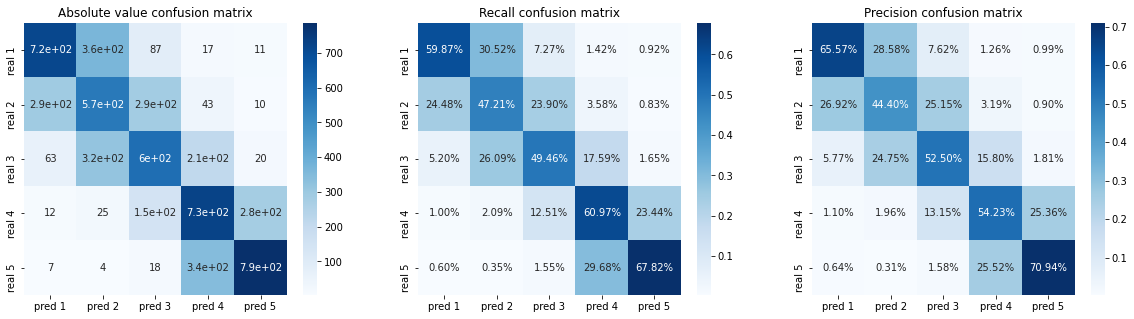

In [22]:
y_true = np.concatenate([y for x, y in test_ds_han], axis=0)
x_test = np.concatenate([x for x, y in test_ds_han], axis=0)
han_model_reg = hp_han.best_model
print(f"best params are {hp_han.best_params}")

y_true = np.argmax(y_true, axis=1, out=None)
y_pred = han_model_reg.predict(x_test)
y_pred = np.argmax(y_pred, axis=1, out=None)

conf_matrix = hp_han.get_confusion_matrix(y_true, y_pred=y_pred, labels=['1', '2', '3', '4', '5'])
hp_han.plot_evaluation_info(conf_matrix)

The first confusion matrix shows data in absolute value.
The second confusion matrix displays the recall matrix ("among the real individuals of class x, which share was predicted as such").
The third confusion matrix displays the precision matrix ("among the predicted individuals of class x, which share was really of this class").

We achieve good results for classes 1 and 5 as they are the most distinctive. The algorithm still struggles to predict more nuanced reviews. Nevertheless, we notice that the embedding makes small mistakes, usually confunding a rating with the next or previous one. Cases where the gap between the truth and the prediction is bigger than 1 star are rare. This is a good indication that the model makes sense even if its accuracy is not optimal

# Insights from Attention Weights

We are having trouble retrieving the attention weights in numpy form (from tensors) but provide the following helper functions to visualise most important words and most important sentence in reviews. We will continue working on the following in the upcoming week.

In [ ]:
from collections import Counter

def get_most_weighted_words(reviews, word_tensor):
    """
    word_tensor (array): shape nb reviews, nb sentences max per review, nb words max per review
    """
    most_weighted_words = []
    for review in word_tensor:
        flatten = review.flatten()
        most_weighted_word_per_review = reviews[np.argmax(flatten)]
        most_weighted_words.append(most_weighted_word_per_review)
    return most_weighted_words

def get_most_weighted_sentences(sentence_tensor):
    """
    sentence_tensor (array): shape nb reviews, nb sentences 
    """
    most_weighted_sentences_idx = []
    for review in sentence_tensor:
        flatten = review.flatten()
        most_weighted_sentences_idx.append(np.argmax(flatten))
    return most_weighted_sentences_idx

most_weighted_words = get_most_weighted_words(x_test, model.word_attention)
most_weighted_sentences_idx = get_most_weighted_sentences(model.document_attention)

words_count = Counter(most_weighted_words)
idx_count = Counter(most_weighted_sentences_idx)

# Show words carrying most weight across all reviews
plt.plot(words_count.keys(), words_count.values())
# Show index of sentences carrying most weight across all reviews
plt.plot(idx_count.keys(), idx_count.values())